# Building an autoencoder <a class='tocSkip'>

**MSDS 2023 | COSCI223: Machine Learning 3**


*Prepared by Kristine Ann M. Carandang*


In this notebook, you will learn (1) how to build a convolutional autoencoder, and (2) describe its unique characteristics compared to a usual feedforward CNN architecture.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# For plotting
import matplotlib.pyplot as plt
from PIL import Image

# Loading the datasets

For this notebook, we will be using the [MNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?highlight=mnist), a dataset of handwritten images.

In [2]:
# Set seed
torch.manual_seed(8)

# Transform the numpy arrays to tensors
transform = transforms.ToTensor()

# Access the MNIST datasets from torchvision
mnist_trainval_data = datasets.MNIST(root='./data/MNIST/train',
                                     train=True,
                                     download=True,
                                     transform=transform)
mnist_train_data, mnist_val_data = random_split(mnist_trainval_data,
                                                [0.7, 0.3])
mnist_test_data = datasets.MNIST(root='./data/MNIST/test',
                                 train=False,
                                 download=True,
                                 transform=transform)

# Load the datasets
mnist_train_loader = DataLoader(dataset=mnist_train_data,
                                batch_size=64,
                                shuffle=True)
mnist_val_loader = DataLoader(dataset=mnist_val_data,
                              batch_size=64,
                              shuffle=True)
mnist_test_loader = DataLoader(dataset=mnist_test_data)

# Building a convolutional autoencoder

## Using `Conv2d` and `ConvTranspose2d` layers

In your previous sessions, you already learned about the [Conv2d layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and what it does to an image. This is also used in autoencoders, primarily for the encoder block. 

Let's again try to apply a `Conv2d layer` in a sample image from the MNIST dataset.

torch.Size([1, 28, 28])

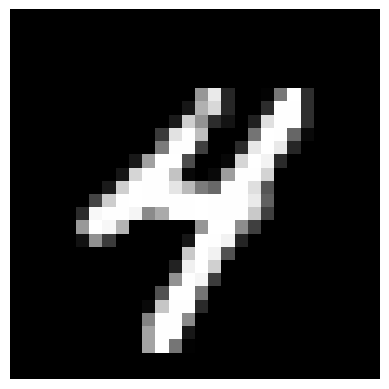

In [3]:
# Access the images from the MNIST train data
mnist_train_dataiter = iter(mnist_train_loader)
mnist_train_images, mnist_train_labels = next(mnist_train_dataiter)
image = mnist_train_images[0]

# Check the shape of the image
display(image.shape)

# Display the sample image
plt.imshow(image.permute(1,2,0).detach().numpy(), cmap='gray');
plt.axis('off');

Note that since we loaded the data directly from [torchvision](https://pytorch.org/vision/stable/index.html), the images are already represented as tensors. Accordingly, to visualize the image, we had to reshape the tensor and convert it to a NumPy array prior to plotting.

Also, note that the image has only 1 channel. As you may already know by now, this information will be necessary when we use a `Conv2D layer`, specifically for the `in_channels` parameter.

Let's now apply the `Conv2d layer` to our image with `128 out_channels` and a `kernel size of 3`.

In [4]:
# Apply a Conv2d
conv = nn.Conv2d(1, 128, 3)
conv_output = conv(image)

# Check the dimensions of the convolved image
display(conv_output.shape)

torch.Size([128, 26, 26])

We can now observe that the number of channels of the image increased to 128 and the shape of the image was reduced.

Shown below are the **filters**, which are basically the weights of the convolutional layer. If you can recall, one characteristic of convolutional neural networks is the network's ability to learn filters unique to a dataset.

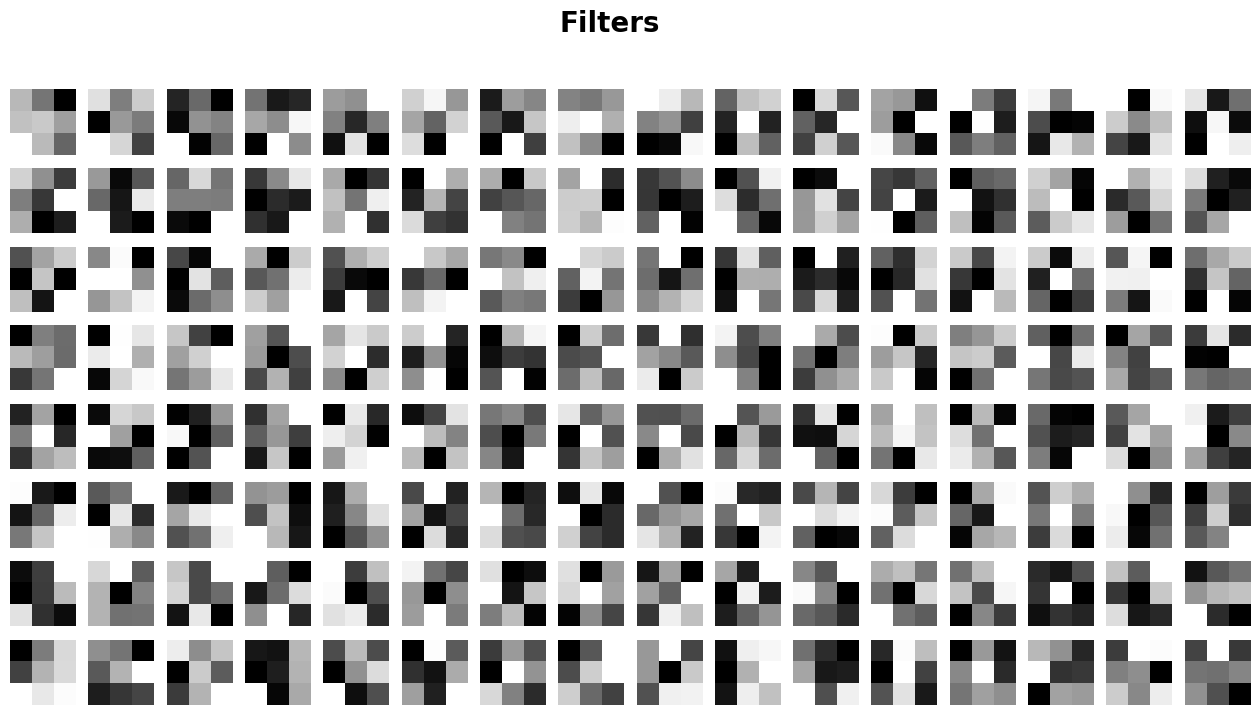

In [5]:
# Get the weights of the convolutional layer
# and convert to a NumPy array
weights = conv.weight.detach().numpy()

# Visualize the filters
ctr = 0
fig, axs = plt.subplots(8, 16, figsize=(16, 8))
for i in range(8):
    for j in range(16):
        axs[i, j].imshow(weights[ctr].reshape(3,3,1), cmap='gray')
        axs[i, j].axis('off')
        ctr +=1
plt.suptitle('Filters\n', weight='bold', fontsize=20)
plt.show()

Let's now look into the feature maps generated by the convolution.

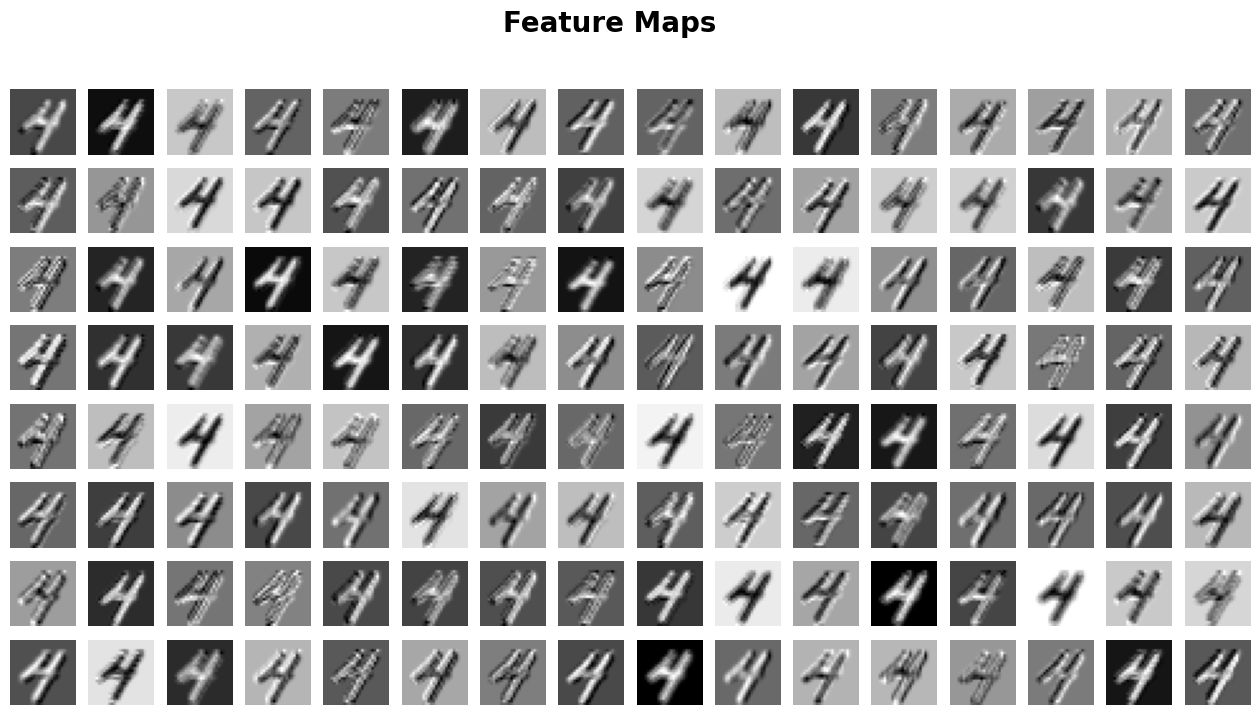

In [6]:
# Visualize the feature maps
ctr = 0
fig, axs = plt.subplots(8, 16, figsize=(16, 8))
for i in range(8):
    for j in range(16):
        axs[i, j].imshow((conv_output
                          .permute(1,2,0)
                          .detach().numpy()[:,:, ctr]),
                         cmap='gray')
        axs[i, j].axis('off')
        ctr +=1
plt.suptitle('Feature Maps\n', weight='bold', fontsize=20)
plt.show()

An important step of an autoencoder is to determine the most salient features of the data; so the direction is to reduce the number of feature maps generated by the encoder block. We will be discussing more about this later. 

For now, let's see if we can reconstruct our input image using these feature maps generated with only one convolutional layer. To do this, we will be using the [ConvTranspose2d layer](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). This is essentially the opposite of the `Conv2d layer`.

In [7]:
# Apply a ConvTranspose2d
convT = nn.ConvTranspose2d(128, 1, 3)
convT_output = convT(conv_output)

<div class="alert alert-block alert-info"> <b>QUESTION:</b> What do you notice about the <b><i>in_channels</b> and <b><i>out_channels</b></i> of the ConvTranspose2d layer?</div>

> *[Input your answer here]*

*To answer this question, review the documentation of the [ConvTranspose2d layer](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). If you want to learn more about deconvolutions, read the article entitled [Deconvolution Networks](https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf).*

Going back to our output image, let's now check its dimensions.

In [8]:
# Check the dimensions of the output image
display(convT_output.shape)

torch.Size([1, 28, 28])

As you can see, the shape of the image is now back to the shape of our original image; however, the images does not look exactly the same as shown below.

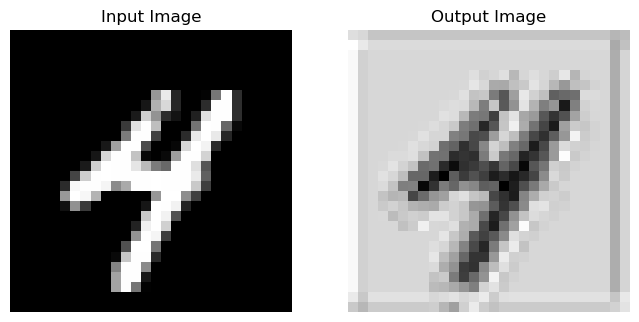

In [9]:
def show_in_out_images(input_image, output_image):
    """Shows """
    fig, ax = plt.subplots(1, 2, figsize=(8,8))
    ax[0].imshow(input_image, cmap='gray');
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    ax[1].imshow(output_image, cmap='gray');
    ax[1].set_title('Output Image')
    ax[1].axis('off')
    plt.show()

# Display the input and output images    
input_image = image.permute(1,2,0).detach().numpy()
output_image = convT_output.permute(1,2,0).detach().numpy()
show_in_out_images(input_image, output_image)

<div class="alert alert-block alert-info"> <b>QUESTION:</b> Why are the images not exactly the same?</div>

> *[Input your answer here]*

*To answer this question, recall what a convolutional layer and a deconvolutional layer do.*

## Utilizing a loss function

We can quantify the difference using a loss function, in particular using **mean squared error (MSE)**. In autoencoders, this is referred to as the **reconstruction error**.

In [10]:
loss = nn.MSELoss()
display(loss(image, convT_output))

tensor(3.3734, grad_fn=<MseLossBackward0>)

<div class="alert alert-block alert-info"> <b>QUESTION:</b> Why is MSE the preferred loss function?</div>

> *[Input your answer here]*

<div class="alert alert-block alert-info"> <b>QUESTION:</b> Is the loss acceptable?</div>

> *[Input your answer here]*

*To answer these questions, recall the purpose of an autoencoder.*

## Starting to build an autoencoder

With these two types of layers and a loss function, we can now start building an autoencoder.

In [11]:
class InitialAutoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()        
        
        # Encoder block
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, 3)
        )
        
        # Decoder block
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 3)
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed

Essentially, the output of the encoder block composed of convolutional layer/s is the **bottleneck** in an autoencoder, and the **reconstructed** image is the output of the decoder block with the bottleneck as the input.

Using one `Conv2D` and one `ConvTranspose2d` however does not impose the **bottleneck** which is an essential characteristic of an autoencoder. In fact, if you implement such, you can expect a low error since you're simply getting the inverse of the other without training the model to learn the most salient features of the image. Let's try to visualize this below.

In [12]:
# Check the device you are using
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on {device}.")

Training on cuda.


In [13]:
# Initialize the model
model = InitialAutoencoder()

# Initialize the loss function
criterion = nn.MSELoss()

# Initialize the optimizer function
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

# Train the model
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for (img, _) in mnist_train_loader:

        reconstructed = model(img)
        loss = criterion(reconstructed, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, reconstructed))

Epoch:1, Loss:0.0014


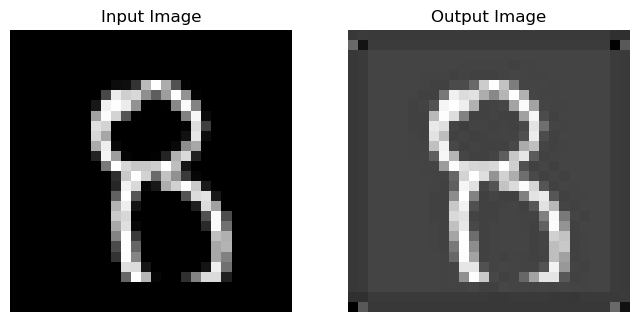

In [14]:
# Display the input and output images    
input_image = outputs[0][1][0].permute(1,2,0).detach().numpy()
output_image = outputs[0][2][0].permute(1,2,0).detach().numpy()
show_in_out_images(input_image, output_image)

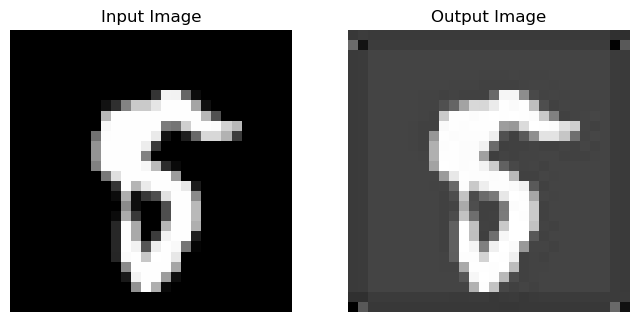

In [15]:
# Display the input and output images    
input_image = outputs[0][1][15].permute(1,2,0).detach().numpy()
output_image = outputs[0][2][15].permute(1,2,0).detach().numpy()
show_in_out_images(input_image, output_image)

## Imposing a bottleneck

How then could we impose a bottleneck?

Recall that an important step of an autoencoder is to determine the most salient features of the data; so the direction is to reduce the number of feature maps generated by the encoder block. During the lecture, we learned that the number of units in the bottleneck should be less than that of the input. We can do this by identifying the size of the bottleneck in the last layer of the encoder block.

```python
class Autoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()        
        
        # Encoder block
        self.encoder = nn.Sequential(
            # first layer
            nn.Conv2d(1, 128, 3)
            
            # last layer: define the size of the bottleneck
            nn.Conv2d(n_channels_of_preceding_layer, 8, 3)
        )
        
        # Decoder block
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 3)
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed
```

In between the first and last layer of the encoder block, you can add other layers used in building CNNs that were already introduced to you. Note however that in so doing, you must consider the decoder block. You will learn more about this during the exercises.

## Adding the last activation function

Additionally, it is important to set the activation function for the last layer of the decoder block. This ensures that the pixel values of our output would correspond to that of the input.

To do this, let's check the pixel values of the images.

In [16]:
# Check the pixel values of the images
print(torch.min(mnist_train_images), torch.max(mnist_train_images))

tensor(0.) tensor(1.)


With this, we now that the values of our images range from 0 to 1. Accordingly, we need an activation function that puts the values of the output image in this range - the **sigmoid function**. Review the activation functions in the [documentation](https://pytorch.org/docs/stable/nn.html?highlight=activation+functions#non-linear-activations-weighted-sum-nonlinearity).

```python
class Autoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()        
        
        # Encoder block
        self.encoder = nn.Sequential(
            # first layer
            nn.Conv2d(1, 128, 3)
            
            # last layer: define the size of the bottleneck
            nn.Conv2d(n_channels_of_preceding_layer, 8, 3)
        )
        
        # Decoder block
        self.decoder = nn.Sequential(
            # first layer
            nn.ConvTranspose2d(128, 1, 3)
            
            # last layer: add the appropriate activation function
            nn.Sigmoid()
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed
```

Similarly, in between the first and last layer of the decoder block, you can add other layers, which should correspond to your encoder block.

## Expanding the initial autoencoder

Let us now incorporate the layers discussed in our Autoencoder. Note that each layer that you add in the encoder block should have a corresponding layer in the decoder block especially for the convolutional and deconvolutional layers.

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()        
        
        # Encoder block
        self.encoder = nn.Sequential(
            
            # first layer
            nn.Conv2d(1, 128, 3),  # Shape: 128, 26, 26
            nn.ReLU(),
            
            # add more conv blocks as needed
            nn.Conv2d(128, 64, 3),  # Shape:  64, 24, 24
            nn.ReLU(),
            nn.Conv2d(64, 32, 3) , # Shape:  32, 22, 22
            nn.ReLU(),
            
            # last layer: define the size of the bottleneck
            nn.Conv2d(32, 8, 3)    # Shape:   8, 20, 20
        )
        
        # Decoder block
        self.decoder = nn.Sequential(
            
            # first layer
            nn.ConvTranspose2d(8, 32, 3),
            nn. ReLU(),
            
            # add more layers as needed 
            # corresponding to the conv blocks of the encoder
            nn.ConvTranspose2d(32, 64, 3),
            nn. ReLU(),
            nn.ConvTranspose2d(64, 128, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 3),
            
            # last layer: add the appropriate activation function
            nn.Sigmoid()
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed

In [18]:
# Initialize the model
model = Autoencoder()

# Initialize the loss function
criterion = nn.MSELoss()

# Initialize the optimizer function
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

# Train the model
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for (img, _) in mnist_train_loader:

        reconstructed = model(img)
        loss = criterion(reconstructed, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, reconstructed))

Epoch:1, Loss:0.0011


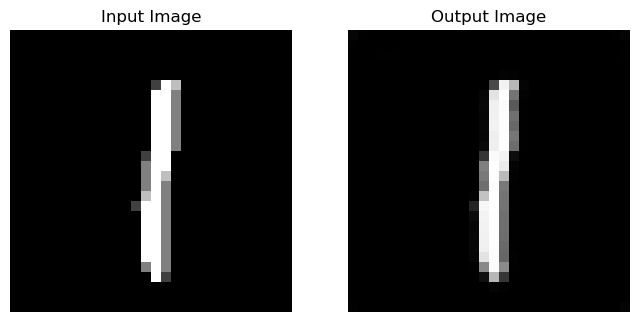

In [19]:
# Display the input and output images    
input_image = outputs[0][1][0].permute(1,2,0).detach().numpy()
output_image = outputs[0][2][0].permute(1,2,0).detach().numpy()
show_in_out_images(input_image, output_image)

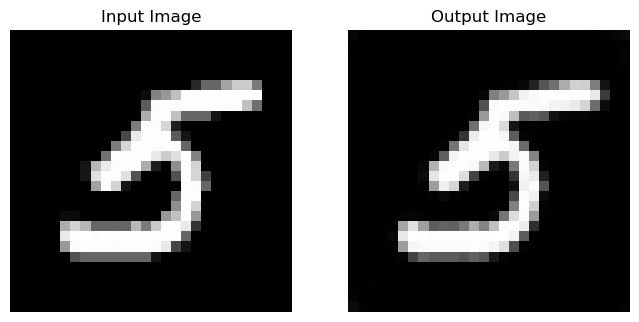

In [20]:
# Display the input and output images    
input_image = outputs[0][1][15].permute(1,2,0).detach().numpy()
output_image = outputs[0][2][15].permute(1,2,0).detach().numpy()
show_in_out_images(input_image, output_image)

We have now implemented a convolutional autoencoder. Let's try expanding this autoencoder more by altering some parameters or adding more layers.

# Exercises

**GENERAL INSTRUCTIONS.** Build an autoencoder with the specifications assigned to your team. You will be given 3 minutes to discuss your learnings in class. Guide questions are provided for each item to help you structure your insights. Indicate your references.

## Altering Conv2d parameters

**SPECIFIC INSTRUCTIONS**
1. Use the sample image stored in the variable `image` for demonstration.
2. Show the dimensions of the `input_image`, the `conv_ouput`, and the `output_image`. Note that the dimensions of the `input_image` and `output_image` should be the same.
3. Build an autoencoder with at least two Conv2D layers with the specific parameter assigned to your team not set to default.
4. Train the model using only one epoch similar to the demonstration earlier.
5. Display the input and output images.

<div class="alert alert-block alert-info"> <b>GUIDE QUESTIONS</b>
<li> How does the application of ConvTranspose2d affected when stride, padding or dilation of the Conv2d layer are not set to default? <li> Are there additional steps needed to be done for the autoencoder to give an output image with similar shape as the input image? Show how this is done.
<li> Note what happens to the shape. Also note `in_channels` and `out_channels`.
</div>

### Using Conv2d with stride > 1

### Using Conv2d with padding > 0

### Using Conv2d with dilation > 1

## Using other layers

Check out the [layers](https://pytorch.org/docs/stable/nn.html#pooling-layers) in the documentation.

**SPECIFIC INSTRUCTIONS**
1. Use the sample image stored in the variable `image` for demonstration.
2. Show the dimensions of the `input_image`, the `conv_ouput`, the `layer_output`, and the `output_image`. 
3. Build an autoencoder using the layer assigned to your team.
4. Train the model using only one epoch similar to the demonstration earlier.
5. Display the input and output images.

<div class="alert alert-block alert-info"> <b>GUIDE QUESTIONS:</b>
    <li> Can the layer be used in an autoencoder? </li>
     <li> If no, explain why it cannot be used in an autoencoder. </li>
    <li> If yes, does the layer have a corresponding "inverse" layer in the decoder?
    <li> If it has a corresponding "inverse" layer in the decoder, what is this layer called? How should this be implemented? Show how this is done. </li>
    <li> If it does not have a corresponding "inverse" layer, should the layer be also included in the decoder?
    <li> What is the effect of using the layer/s in the outputs of the autoencoder?
   
</div>

### Adding a MaxPool2D layer

### Adding a BatchNorm2d layer

### Adding a Dropout layer

# References <a class='tocSkip'>

- PyTorch Documentation
- Original Paper (2006): https://science.sciencemag.org/content/313/5786/504
- Textbook: https://www.deeplearningbook.org/contents/autoencoders.html
- Textbook: https://frcs.github.io/4C16-LectureNotes/autoencoders.html
- Code-along in PyTorch: https://www.youtube.com/watch?v=zp8clK9yCro